In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from models import SimpleRNN, LSTM
#from lstm_models import LSTM
import utils_2 as ut2
from traindata import trainData



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

sns.set_style("darkgrid")


import numpy as np
from tqdm import tqdm



np.random.seed(seed=77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **data**

In [2]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file1_080124.mat"
#cutoff = [8/1000, 11/1000]

data = trainData(fpath, fname, 'Amplitude')
train, val, test = data.split_data('Amplitude')

In [3]:
# sub sampleo

train = utils.subsample(train, 2)
val = utils.subsample(val, 2)
test = utils.subsample(test, 2)

In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
val_scaled = scaler.transform(val.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [5]:
x_train, y_train = ut2.create_sequences(train_scaled[:10000], 1000, 1)
x_train = x_train.squeeze()
y_train = y_train.squeeze()

x_val, y_val = ut2.create_sequences(val_scaled[:5000], 1000, 1)
x_val = x_val.squeeze()
y_val = y_val.squeeze()

x_test, y_test = ut2.create_sequences(test_scaled[:3000], 1000, 1)
x_test = x_test.squeeze()
y_test = y_test.squeeze()

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((9000, 1000), (9000,), (4000, 1000), (4000,), (2000, 1000), (2000,))

## **modelo svr**

In [21]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
 

In [7]:
from sklearn.model_selection import PredefinedSplit

model = SVR()
param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
         'C' : [1,5,10],
         'degree' : [3,8],
         'coef0' : [0.01,10,0.5],
         'gamma' : ('auto','scale')}

#array para el predefinedsplit
test_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold)

#concateno matrices de training y validación
xTrainVal = np.concatenate((x_train,x_val),axis=0)
yTrainVal = np.concatenate((y_train,y_val),axis = 0)


grid=GridSearchCV(SVR( ), param, n_jobs = -1, verbose = 2)
grid.fit(xTrainVal,yTrainVal)

print('Mejor Estimator: ', grid.best_estimator_)
print('Mejores Parametros: ', grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   2.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   2.4s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   2.5s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   2.7s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   2.9s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   4.5s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   4.4s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   4.4s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   4.3s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=sigmoid; total time=   5.4s
[CV] END C=1, coef0=0.01, degree=3, gam

In [22]:
model  = SVR(C = 10, coef0 = 0.5, degree = 3, gamma = 'auto', kernel= 'sigmoid')

In [26]:
model.fit(x_train, y_train)

SVR(C=10, coef0=0.5, gamma='auto', kernel='sigmoid')

## **testeo**

In [10]:
def rollingWindowPrediction_SVR(model, x_test, steps=50):
    output = []
    N = x_test.shape[-1]

    for elem in tqdm(x_test):
        elem = elem.reshape(1, -1)
        #print(elem)
        test_aux = []
        count = 0
        while count < steps:
            #print(count)
            pred = model.predict(elem)
            test_aux.append(pred[0])
            elem = np.append(elem, pred)[1:].reshape(1,-1)
            #print(elem.shape)
            count += 1

        output.append(test_aux)
    return output

In [164]:
import pickle
# save the model to disk
filename = 'SVR_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [8]:
import pickle
filename = 'SVR_model.sav'
# load model
model = pickle.load(open(filename, 'rb'))

In [11]:
test_pred = rollingWindowPrediction_SVR(model, x_test, steps = 50)

100%|██████████| 2000/2000 [00:11<00:00, 169.52it/s]


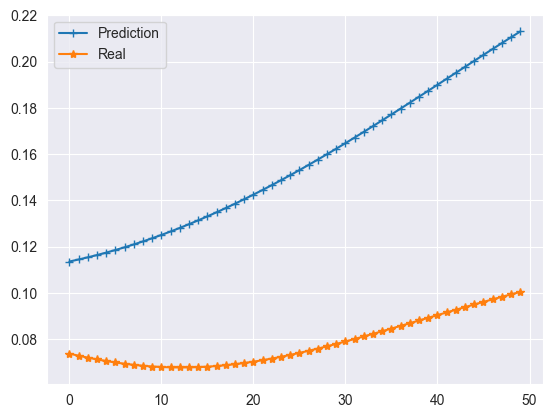

In [12]:
i = 65

plt.plot(test_pred[i],'-+', label='Prediction')
plt.plot(y_test[i:i+50], '-*',label='Real')
plt.legend()
plt.show()

In [15]:
import errores as er
x = er.error_metrics(test_pred[:-49], test_scaled[:3000], 50)

Mean Squared Error: 0.010728920564516907
Mean Absolute Percentage Error: 1.415233562003751
R2 Score: -7.697602488088966
Root Mean Squared Error: 0.09783670991200337
